In [29]:
import os
import importlib
from itertools import product

import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
import torch as th

from tqdm.auto import tqdm

from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import VecEnvWrapper, VecEnv, DummyVecEnv
from stable_baselines3.common.vec_env import VecTransposeImage

import utils.import_envs  # noqa: F401 pylint: disable=unused-import
from utils.utils import StoreDict
from utils import ALGOS, create_test_env, get_latest_run_id, get_saved_hyperparams

In [30]:
########### Set Device ############
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
dtype = th.float32
th.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda


## set arguments

In [31]:
env_id = "BreakoutNoFrameskip-v4"
folder = "logs"
algo = "a2c"
n_timesteps = 10000
num_threads = -1
n_envs = 1
exp_id = 3
verbose = 1
no_render = False
deterministic = False
load_best = True
load_checkpoint = None
norm_reward = False
seed = 0
reward_log = ''
env_kwargs = None

## Load up the best model and environment

In [32]:
# Sanity checks
if exp_id > 0:
    log_path = os.path.join(folder, algo, '{}_{}'.format(env_id, exp_id))
else:
    log_path = os.path.join(folder, algo)
    
found = False
for ext in ['zip']:
    model_path = os.path.join(log_path, f'{env_id}.{ext}')
    found = os.path.isfile(model_path)
    if found:
        break

if load_best:
    model_path = os.path.join(log_path, "best_model.zip")
    found = os.path.isfile(model_path)

if load_checkpoint is not None:
    model_path = os.path.join(log_path, f"rl_model_{load_checkpoint}_steps.zip")
    found = os.path.isfile(model_path)

if not found:
    raise ValueError(f"No model found for {algo} on {env_id}, path: {model_path}")

if algo in ['dqn', 'ddpg', 'sac', 'td3']:
    n_envs = 1

set_random_seed(seed)

if num_threads > 0:
    if verbose > 1:
        print(f"Setting torch.num_threads to {num_threads}")
    th.set_num_threads(num_threads)

is_atari = 'NoFrameskip' in env_id

stats_path = os.path.join(log_path, env_id)
hyperparams, stats_path = get_saved_hyperparams(stats_path, norm_reward=norm_reward, test_mode=True)
env_kwargs = {} if env_kwargs is None else env_kwargs

log_dir = reward_log if reward_log != '' else None

env = create_test_env(env_id, n_envs=n_envs,
                      stats_path=stats_path, seed=seed, log_dir=log_dir,
                      should_render=not no_render,
                      hyperparams=hyperparams,
                      env_kwargs=env_kwargs)

model = ALGOS[algo].load(model_path, env=env)

obs = env.reset()

Stacking 4 frames


In [34]:
def create_circular_mask(h, w, center, radius=5):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y-center[0])**2)
    mask = dist_from_center <= radius
    return np.array(mask, dtype=np.float32)

def max_k(k, iterator, key=lambda x: x):
    items = [None for _ in range(k)]
    values = [-float('inf') for _ in range(k)]
    for item in iterator:
        val = key(item)
        for i in range(k):
            if val > values[i]:
                items.insert(i, item)
                items.pop()
                values.insert(i, val)
                values.pop()
                break
    return items

loss_fn = th.nn.MSELoss()
def policy_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.action_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.action_net(latent)
    return loss_fn(baseline, modified).item()

def value_saliency(model, obs, loc, radius=5, device='cuda'):
    obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    baseline = model.policy.value_net(latent)
    M = create_circular_mask(84, 84, center=loc, radius=radius)
    for k in range(4):
        img = obs_transposed[0, k, :, :]
        A = scipy.ndimage.gaussian_filter(img, 3)
        obs_transposed[0, k, :, :] = img*(1 - M) + A*M
    latent, _, _ = model.policy._get_latent(th.from_numpy(obs_transposed).to(device))
    modified = model.policy.value_net(latent)
    return loss_fn(baseline, modified).item()

def invert_preprocessing(loc):
    x, y = loc
    return (int(210/84*x), int(160/84*y))

In [35]:
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

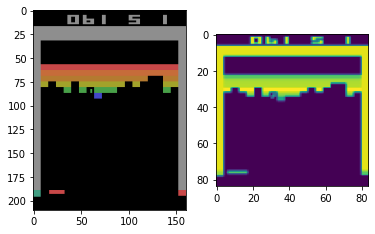

In [36]:
plt.subplot(1, 2, 1)
plt.imshow(env.get_images()[0])
plt.subplot(1, 2, 2)
plt.imshow(obs[0, :, :, 3])

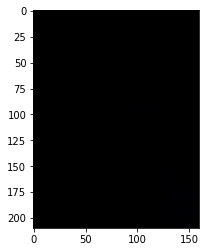

In [52]:
locs = max_k(15, product(range(0, 84, 5), range(0, 84, 5)), key=lambda e: policy_saliency(model, obs, e, radius=6))

# obs_transposed = VecTransposeImage.transpose_image(np.copy(obs))
# for loc in locs:
#     M = create_circular_mask(84, 84, center=loc, radius=6)
#     for k in range(4):
#         img = obs_transposed[0, k, :, :]
#         A = scipy.ndimage.gaussian_filter(img, 3)
#         obs_transposed[0, k, :, :] = img*(1 - M) + A*M
        
real_image = env.get_images()[0]
real_image = real_image / real_image.max()
real_image = real_image * 0.4
for loc in locs:
    spot = 1.0*create_circular_mask(210, 160, center=invert_preprocessing(loc), radius=12)
    real_image[:, :, 2] += spot
    
plt.imshow(real_image)

In [53]:
matplotlib.use("Agg")
import matplotlib.animation as manimation

import warnings
warnings.filterwarnings("ignore")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

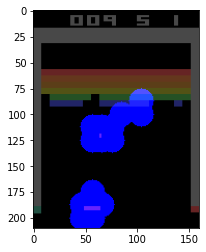

In [56]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()
imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "breakout_policy_saliency.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        locs = max_k(15, product(range(0, 84, 5), range(0, 84, 5)), key=lambda e: policy_saliency(model, obs, e, radius=6))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        screenshot = screenshot * 0.4
        for loc in locs:
            spot = 1.0*create_circular_mask(210, 160, center=invert_preprocessing(loc), radius=12)
            screenshot[:, :, 2] += spot
        imshow.set_data(screenshot)
        writer.grab_frame()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

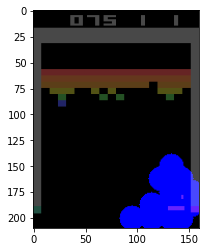

In [57]:
TIMESTEPS = 300

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()

for i in range(1100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "breakout_policy_saliency_later.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        locs = max_k(15, product(range(0, 84, 5), range(0, 84, 5)), key=lambda e: policy_saliency(model, obs, e, radius=6))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        screenshot = screenshot * 0.4
        for loc in locs:
            spot = 1.0*create_circular_mask(210, 160, center=invert_preprocessing(loc), radius=12)
            screenshot[:, :, 2] += spot
        imshow.set_data(screenshot)
        writer.grab_frame()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

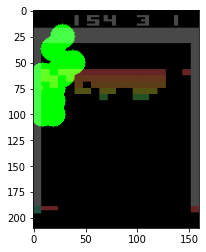

In [59]:
TIMESTEPS = 600

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title=f"Breakout Policy Saliency Map", artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=20, metadata=metadata)

fig, ax = plt.subplots(1, 1)

obs = env.reset()

for i in range(1100):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    if done:
        break

imshow = ax.imshow(env.get_images()[0])
with writer.saving(fig, "breakout_value_saliency_later.mp4", dpi=200):
    for i in tqdm(range(TIMESTEPS)):
        action, _states = model.predict(obs, deterministic=False)
        obs, reward, done, info = env.step(action)
        if done:
            break
        locs = max_k(15, product(range(0, 84, 5), range(0, 84, 5)), key=lambda e: value_saliency(model, obs, e, radius=6))
        screenshot = env.get_images()[0]
        screenshot = screenshot / screenshot.max()
        screenshot = screenshot * 0.4
        for loc in locs:
            spot = 1.0*create_circular_mask(210, 160, center=invert_preprocessing(loc), radius=12)
            screenshot[:, :, 1] += spot
        imshow.set_data(screenshot)
        writer.grab_frame()